In [19]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install azureml-core
!pip install azureml-dataset-runtime --upgrade

In [27]:
import os

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
import torchvision.models as models

from tqdm import tqdm
import psutil


In [20]:
# azureml-core of version 1.0.72 or higher is required
# azureml-dataprep[pandas] of version 1.1.34 or higher is required
from azureml.core import Workspace, Dataset

subscription_id = '4b4a78e1-8ee7-4425-a0eb-da6808c31b58'
resource_group = 'team1'
workspace_name = '1team'

workspace = Workspace(subscription_id, resource_group, workspace_name)

dataset = Dataset.get_by_name(workspace, name='doors_20230507_084332')
df = dataset.to_pandas_dataframe()

Performing interactive authentication. Please follow the instructions on the terminal.


Interactive authentication successfully completed.


Write all function related to geometric box manipulations and visualizations

In [21]:
height, width = 4032, 3024

def box_corner_to_center(box):
    """Convert from (upper-left, lower-right) to (center, width, height)."""
    x1, y1, x2, y2 = box[0], box[1], box[2], box[3]
    cx = (x1 + x2) / 2
    cy = (y1 + y2) / 2
    w = x2 - x1
    h = y2 - y1
    box = torch.stack((cx, cy, w, h), axis=-1)
    return box

def box_center_to_corner(box):
    """Convert from (center, width, height) to (upper-left, lower-right)."""
    cx, cy, w, h = box[0], box[1], box[2], box[3]
    x1 = cx - 0.5 * w
    y1 = cy - 0.5 * h
    x2 = cx + 0.5 * w
    y2 = cy + 0.5 * h
    box = torch.stack((x1, y1, x2, y2), axis=-1)
    return box

def center_box_to_plt(box):
    cx, cy, w, h = box[0], box[1], box[2], box[3]
    return matplotlib.patches.Rectangle((cx-w/2,cy-h/2),w,h,facecolor="none",edgecolor='green')

def corner_box_to_plt(box):
    box = box_corner_to_center(box)
    return center_box_to_plt(box)

Dataloader:

In [22]:
resizer = torchvision.transforms.Resize((400,400))

class DoorDataset(torch.utils.data.Dataset):
    def __init__(self, data):
        self.urls = data['image_url']
        self.labels = data['label']

    def __getitem__(self, index):
        im_name = str(self.urls[index]).split('/')[-1]
        file_name = f'./drive/MyDrive/image_raw/{im_name}'
        # x = cv2.imread(file_name)
        x = torchvision.io.read_image(file_name)
        x = torch.tensor(x).float() / 255
        x = resizer(x)
        # x = x.to(device)

        y1 = self.labels[index][0]["topX"]
        y2 = self.labels[index][0]["topY"]
        y3 = self.labels[index][0]["bottomX"]
        y4 = self.labels[index][0]["bottomY"]
        y = torch.tensor([y1,y2,y3,y4]).float()
        # y = y.to(device)
        return x, y

    def __len__(self):
        return len(self.urls)


dataset = DoorDataset(df)

n_data = len(dataset)
n_train = int(0.85*n_data)
n_test = n_data - n_train

train_set, test_set = torch.utils.data.random_split(dataset, [n_train, n_test])
trainloader = DataLoader(train_set, batch_size=128, shuffle=True)
testloader = DataLoader(test_set, batch_size=128)

Neural Network Definition:

In [23]:
class BoundingBoxRegressor(nn.Module):
    def __init__(self):
        super(BoundingBoxRegressor, self).__init__()
        
        # Lade ein vortrainiertes ResNet-18-Modell
        resnet18 = models.resnet18(pretrained=True)
        
        # Entferne den letzten Fully-Connected Layer, um Features zu extrahieren
        layers = list(resnet18.children())[:-1]
        self.feature_extractor = nn.Sequential(*layers)

        # Hinzufügen eines neuen Fully-Connected Layers für die Bounding Box Regression
        self.regressor = nn.Linear(512, 4)

        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Extrahiere Features aus dem Eingabebild
        features = self.feature_extractor(x)
        
        # Flattening
        features = features.view(features.size(0), -1)

        # Berechne die Seitenlängen der Bounding Box
        bbox_lengths = self.regressor(features)
        # bbox_lengths = self.sigmoid(bbox_lengths)
        
        return bbox_lengths

In [24]:
print(psutil.virtual_memory()[2])
version=0

16.6


In [25]:

box_net = BoundingBoxRegressor()

box_net.load_state_dict(torch.load('box_net_v3_l0.03.pth'))

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


<All keys matched successfully>

In [ ]:
version += 1
# box_net = BoundingBoxRegressor()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
for name, param in box_net.named_parameters():
    print(name, param.shape)

In [ ]:
import pickle

In [26]:
version += 1

# hyperparameters
epochs = 20
learning_rate = 0.01

# instanciate model
print("---------- Creating model ----------")
# 
# box_net.to('cuda')

optimizer = optim.Adam(box_net.parameters(), lr=learning_rate)
loss_function = nn.MSELoss()

loss_storage = list()

min_loss = 1e6

print("---------- Start training ----------")
for epoch in range(epochs):

    loss = 0
    for X, Y in trainloader:

        box_net.train()
        
        # reset gradient
        optimizer.zero_grad() 
        
        # compute loss
        # X = X.to('cuda')
        # Y = Y.to('cuda')
        Y_pred = box_net(X)
        train_loss = loss_function(Y, Y_pred)
        
        # compute gradient + perform gradient decent
        train_loss.backward()
        optimizer.step()
        
        loss += train_loss.item()

    # epoch training loss
    loss = loss / len(trainloader)

    if loss < min_loss:
      min_loss = loss
      filename = f"box_net_v{version}_l{min_loss:.2f}.pth"
      torch.save(box_net.state_dict(), filename)
    
    # compute test loss
    with torch.no_grad():
        box_net.eval()
        test_loss = 0
        for X_test, Y_test in testloader:
            # X_test = X_test.to('cuda')
            # Y_test = Y_test.to('cuda')

            Y_test_pred = box_net(X_test)
            test_loss += loss_function(Y_test, Y_test_pred).item()

        test_loss = test_loss / len(testloader)
        
    loss_storage.append((loss, test_loss))
        
    print("epoch : {}/{}, loss = {:.4f}, test loss = {:.4f}".format(epoch + 1, epochs, loss, test_loss)) 


torch.save(box_net.state_dict(), filename)

print("Done.")

---------- Creating model ----------
---------- Start training ----------


<ipython-input-22-cbe49e34749e>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x).float() / 255
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


epoch : 1/20, loss = 0.9853, test loss = 13.1594
epoch : 2/20, loss = 0.6048, test loss = 0.2002
epoch : 3/20, loss = 0.2355, test loss = 0.2910
epoch : 4/20, loss = 0.1638, test loss = 0.0909


Engine process terminated with returncode=-2
RuntimeError('Engine process terminated. Please try running again. |session_id=l_9c205f23-bea8-4c76-920d-ea264f1a9f51')


KeyboardInterrupt: ignored

Print Training Curves

In [ ]:
filename = f"box_net_v{version}_l{min_loss:.2f}.pth"
torch.save(box_net.state_dict(), filename)

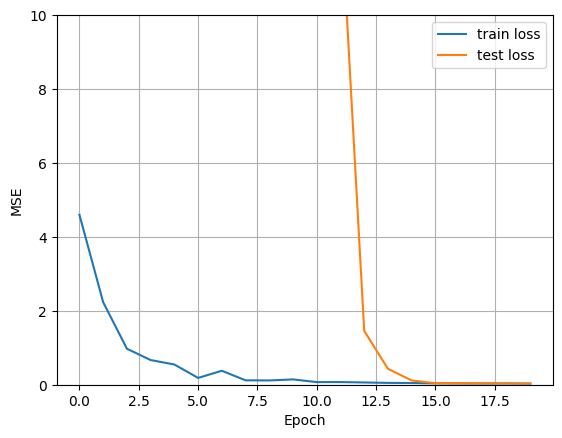

In [ ]:
train_loss = [loss for loss, _ in loss_storage]
test_loss = [loss for _, loss in loss_storage]

plt.figure()
plt.plot(train_loss, label='train loss')
plt.plot(test_loss, label='test loss')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()
plt.grid()
plt.ylim([0,10])
plt.show()

<ipython-input-22-cbe49e34749e>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x).float() / 255
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Predicted box: tensor([  0.7880,  91.4820, 203.6770, 241.1413])
Predicted box: tensor([-16.6973, 121.7405, 236.9975, 337.9728])
Predicted box: tensor([ -4.0241, 115.1142, 202.7680, 318.9087])
Predicted box: tensor([  0.6845, 105.9130, 209.0835, 277.4444])
Predicted box: tensor([-15.7130, 105.7085, 199.7861, 310.2244])
Predicted box: tensor([-102.3773,  107.1296,  314.7259,  289.6029])
Predicted box: tensor([ -1.6720, 108.7701, 215.6834, 281.6752])
Predicted box: tensor([  0.7627,  87.5990, 198.7631, 234.0661])
Predicted box: tensor([-77.9252,  89.8492, 230.3280, 335.4497])
Predicted box: tensor([-8.2041e-02,  9.8613e+01,  2.1085e+02,  2.4974e+02])
Predicted box: tensor([-66.8804,  88.7101, 209.1785, 349.8595])
Predicted box: tensor([-118.4842,   93.8968,  320.4683,  307.6678])
Predicted box: tensor([  0.7130,  90.9387, 202.0829, 238.4861])
Predicted box: tensor([-128.1941,   59.3251,  305.1172,  322.6146])
Predicted box: tensor([-93.2256,  84.0474, 266.9658, 296.0982])
Predicted box: t

KeyboardInterrupt: ignored

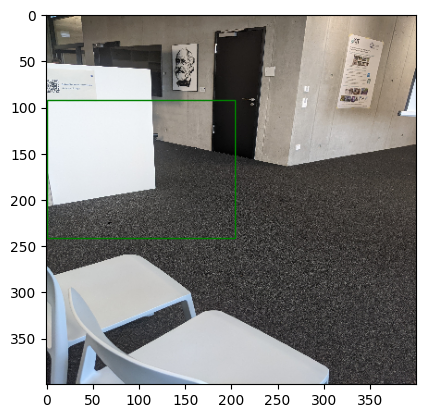

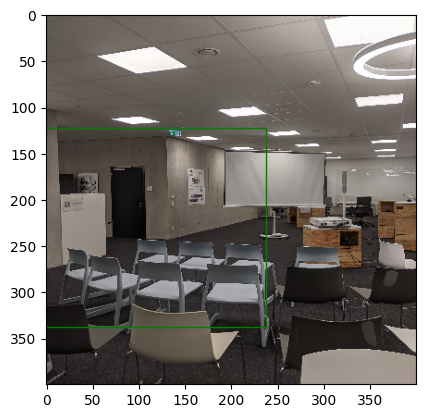

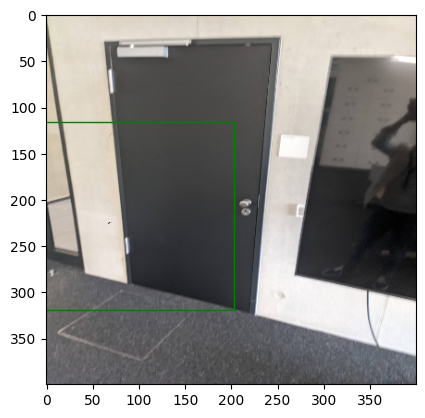

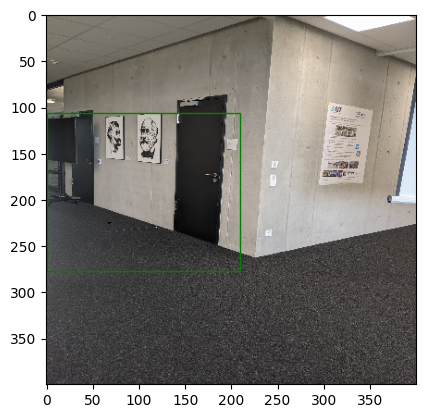

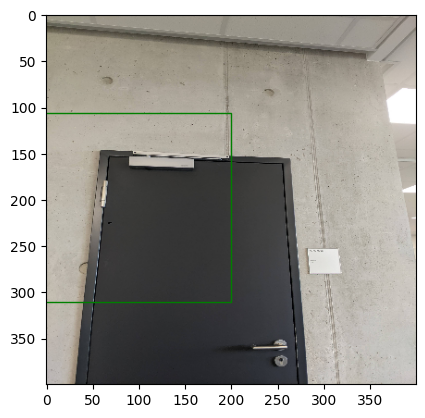

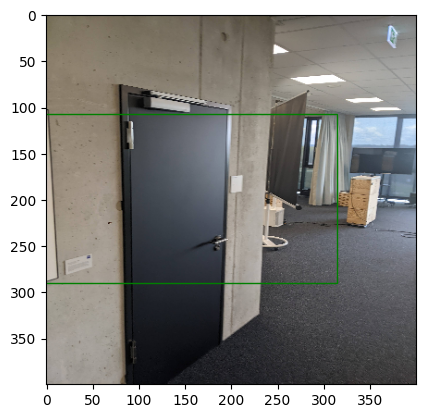

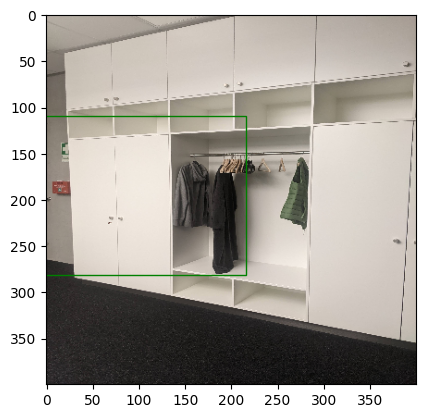

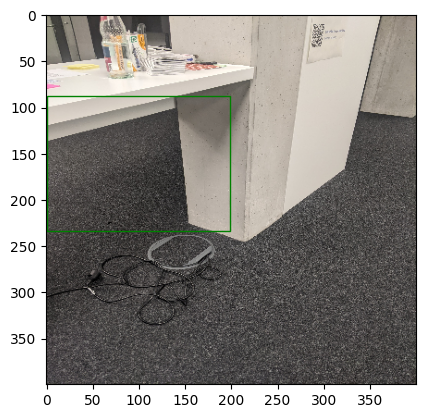

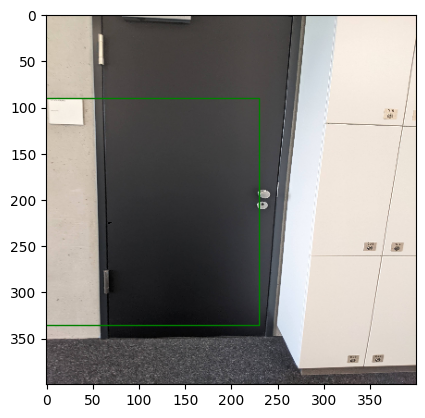

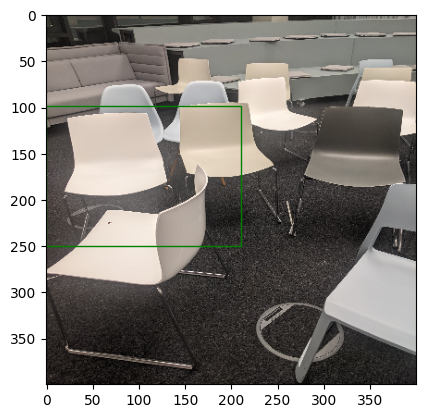

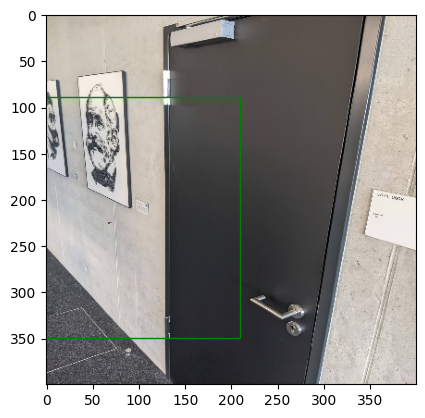

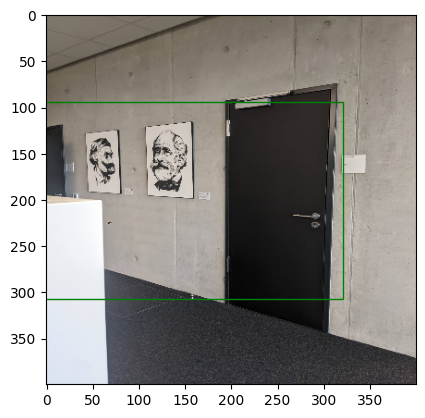

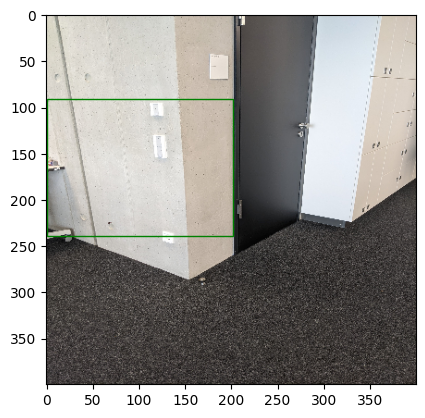

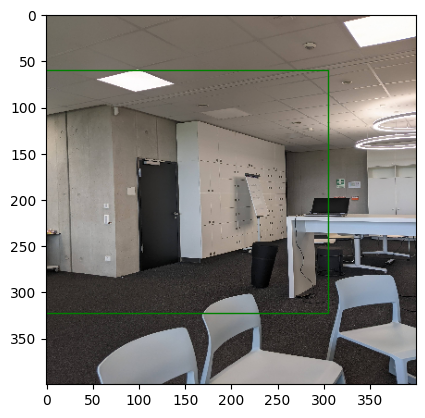

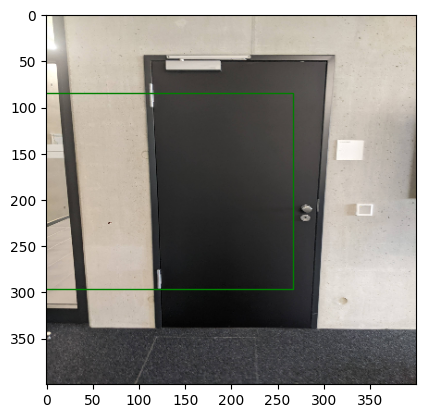

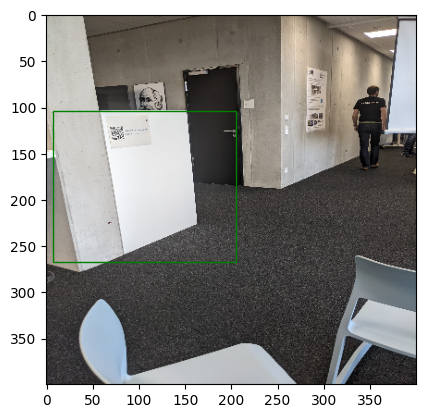

In [29]:
testloader = DataLoader(test_set, batch_size=2, shuffle=True)

with torch.no_grad():
  box_net.eval().to('cpu')
  for X_test, Y_test in testloader:

      Y_pred = box_net(X_test)
      Y_pred = Y_pred * torch.tensor([400, 400, 400, 400])

      for idx in range(2):
        fig, ax = plt.subplots()
        im = torch.swapaxes(torch.swapaxes(X_test[idx],0,2),0,1)
        ax.imshow(im.cpu().numpy())
        print(f'Predicted box: {Y_pred[idx]}')
        ax.add_patch(corner_box_to_plt(Y_pred[idx].cpu()))

